In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import Series, DataFrame
from datetime import date
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
race = pd.read_csv('.../races.csv')

In [5]:
runs = pd.read_csv('.../runs.csv')

In [6]:
race = race.drop(race.columns[[9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36]],axis=1)
# prize and in game details should have no effect on pre-game betting 

In [7]:
#runs.info()

In [8]:
# redefine raceclass

race_classes=pd.DataFrame(race['horse_ratings'].str.split('-').tolist(),columns=['race_class_hi','race_class_lo'])
new_race=pd.concat([race,race_classes],axis=1)

In [9]:
def rc(x):
    
    for i in xrange(len(new_race)):
        if x.values[i]=='G':
            return 'G'
        elif x.values[i][-1]=='+':
            return 1
        elif 41<=int(x.values[i])<=60:
            return 4
        elif 61<=int(x.values[i])<=80:
            return 3
        elif 81<=int(x.values[i])<=100:
            return 2
        elif 101<=int(x.values[i])<=120:
            return 1
        else:
            return 5

In [10]:
new_race['rcc']=pd.DataFrame(new_race['race_class_hi']).apply(rc,axis=1)

In [11]:
# change the 'date' column into datetime format
new_race['date']=pd.to_datetime(new_race['date'])

In [12]:
raceST = new_race[new_race['venue']=='ST']
raceHV = new_race[new_race['venue']=='HV']

In [13]:
raceST_turf = raceST[raceST['surface']==0]
raceST_dirt = raceST[raceST['surface']==1]
# there is no dirt course in Happy Valley

In [14]:
run = pd.merge(new_race,runs,on='race_id')

In [15]:
def pos1_3(x):
    if x==1:
        return 1
    elif x==2:
        return 1
    elif x==3:
        return 1
    else:
        return 0

In [16]:
run['position1_3']=runs['result'].apply(pos1_3)
# prepare for place, triple-trio

In [17]:
def rest(run):
    run['horse_rest_days']=(run['date'].shift(-1)-run['date']).shift(1)
    return run

In [18]:
run=run.sort_values(['horse_id','date'])

In [19]:
run=run.groupby(['horse_id']).apply(rest)

In [20]:
run['horse_rest_days'].fillna('50 days',inplace=True)
# consider Nan indicates that race is the first of the season for the horse, which here generalise its rest is 50 days

In [21]:
run['horse_rest_days']=[int(i.days) for i in (run.horse_rest_days)]
# delete words days and change into int type

In [22]:
run.head()

,race_id,date,venue,race_no,config,surface,distance,going,horse_ratings,race_class_hi,...,time4,time5,time6,finish_time,win_odds,place_odds,trainer_id,jockey_id,position1_3,horse_rest_days
42543,3396,2001-11-04,ST,2,A,0,1200,GOOD,80-60,80,...,NaN,NaN,NaN,72.08,34.0,10.0,63,21,0,50
43723,3489,2001-12-09,ST,5,A+3,0,1200,GOOD,80-60,80,...,NaN,NaN,NaN,70.62,76.0,11.0,63,40,0,35
47509,3794,2002-06-02,ST,1,B,0,1200,GOOD TO FIRM,60-40,60,...,NaN,NaN,NaN,71.29,39.0,8.7,73,21,0,175
48016,3835,2002-06-23,ST,6,A,0,1200,GOOD TO FIRM,60-40,60,...,NaN,NaN,NaN,71.43,99.0,22.0,73,40,0,21
48647,3886,2002-07-14,ST,3,B+2,0,1600,GOOD TO FIRM,60-40,60,...,23.61,NaN,NaN,96.74,36.0,9.2,73,177,0,21


In [23]:
run['distance'].value_counts()
# lets focus on 1200m races

1200    24697
1400    14565
1650    13253
1000     8524
1600     8329
1800     7320
2000     1463
2200     1034
2400      262
Name: distance, dtype: int64

In [24]:
run['rcc'].value_counts()
# lets focus on class 4

4    28324
3    23416
5    11409
2     8632
1     4192
G     3474
Name: rcc, dtype: int64

In [25]:
run_1200 = run[run['distance']==1200]
run_1200_4 = run_1200[run_1200['rcc']==4]
run_1200_4_turf = run_1200_4[run_1200_4['surface']==1]

# class 4 is chosen because of the following reason:
# 1. it was which most games held
# 2. since these jockeys and trainer are based in HK, they would less likely be one-time candidates.

In [26]:
# Data preparation for WIN and 3T prediction

In [27]:
race_ML = run_1200_4_turf.drop(run_1200_4_turf.columns[[0,1,2,3,4,5,6,7,8,9,10,11,13,14,16,17,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43]],axis=1)
# in game details should have no effect on pre-game betting 

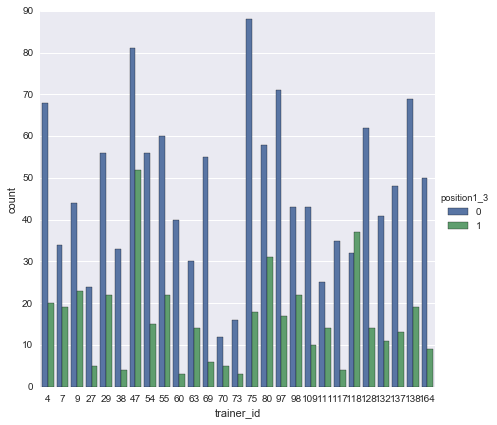

In [28]:
sns.factorplot('trainer_id',hue='position1_3',kind='count',data=race_ML,size=6, aspect=1)

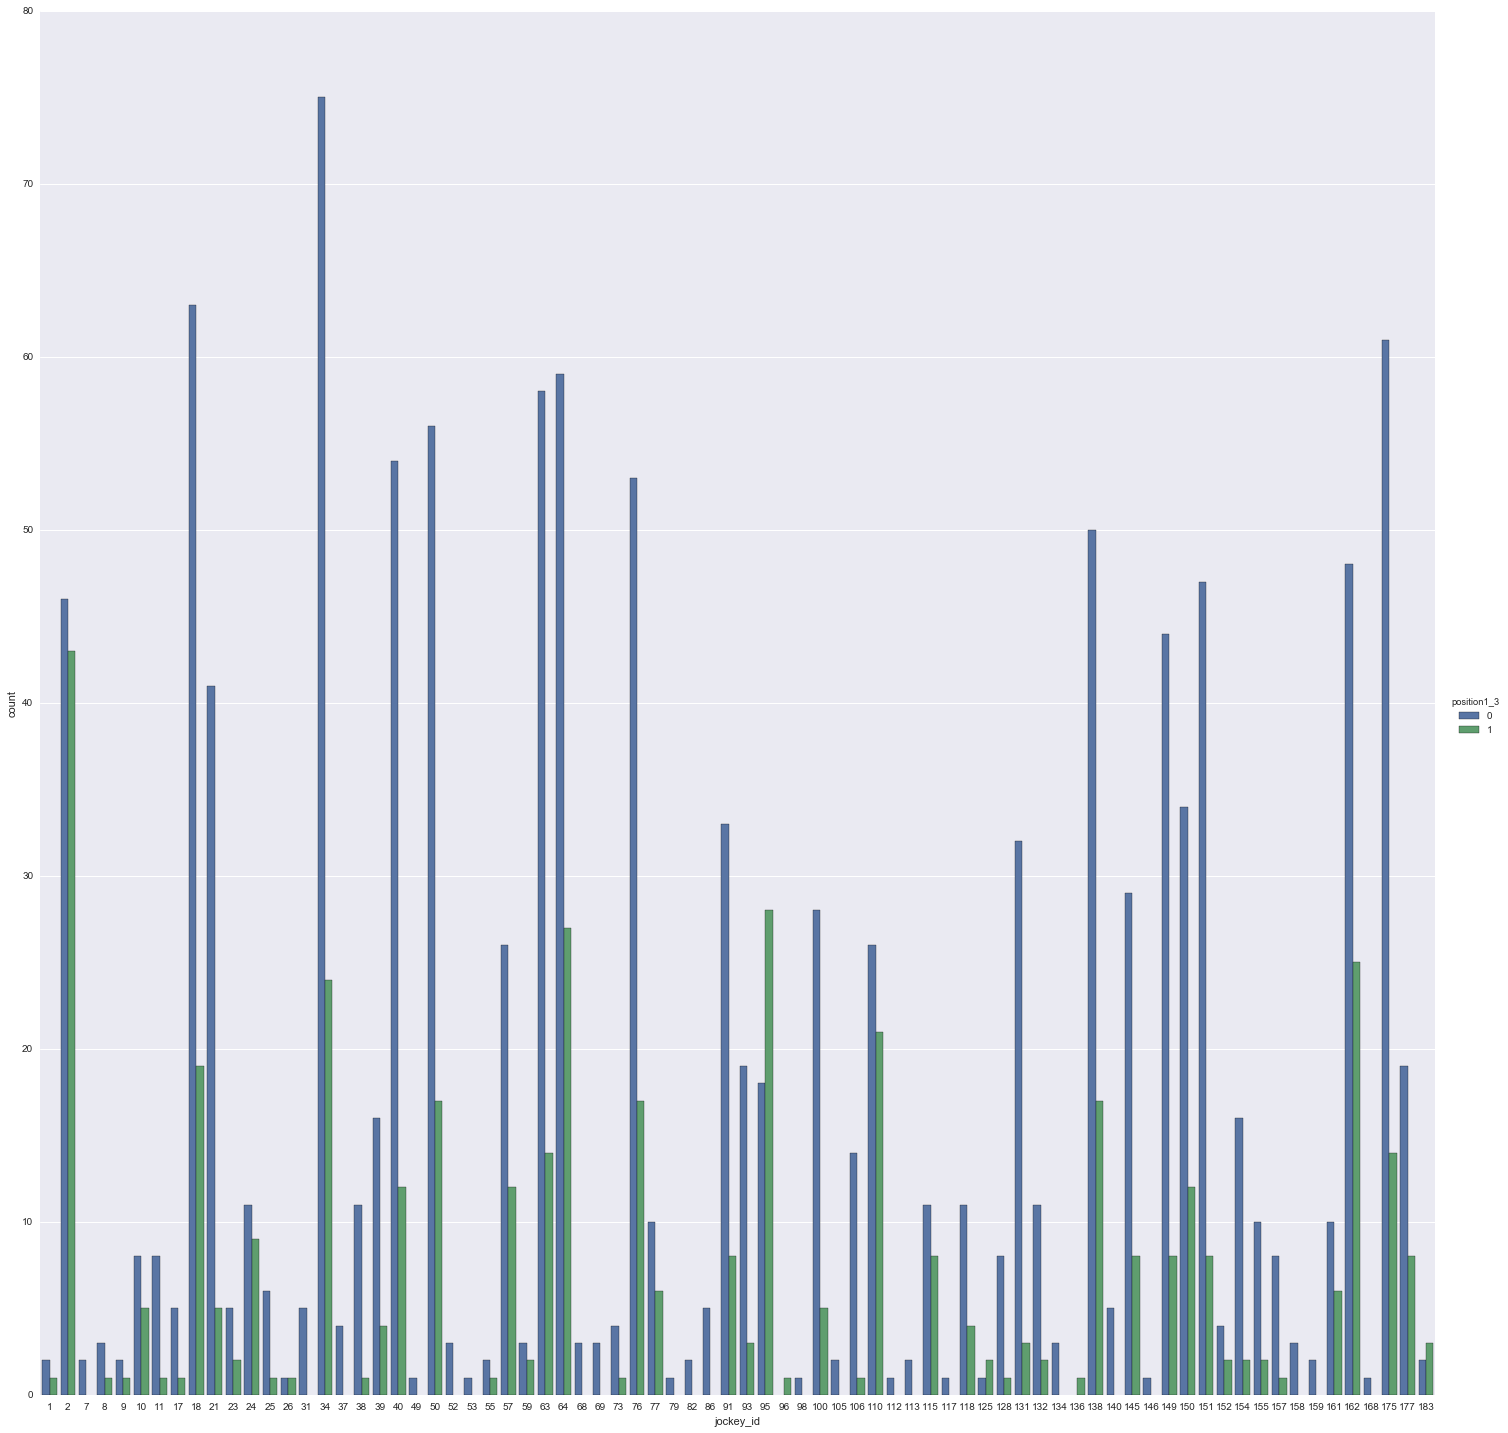

In [29]:
sns.factorplot('jockey_id',hue='position1_3',data=race_ML,size=20, aspect=1,kind='count')

In [41]:
race_ML=race_ML.dropna()
y_won = race_ML['won']
y_position1_3 = race_ML['position1_3']
X=race_ML.drop(race_ML.columns[[1,13]],axis=1)

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [42]:
X_won=pd.get_dummies(X)

In [39]:
lg=LogisticRegression()

In [45]:
X_train,X_test,Y_train,Y_test= train_test_split(X_won,y_won)

In [49]:
lg.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
won_prediction = lg.predict(X_test)

In [51]:
print metrics.accuracy_score(Y_test,won_prediction)

0.923076923077


In [53]:
lg1=LogisticRegression()

In [67]:
X_train1,X_test1,Y_train1,Y_test1= train_test_split(X_won,y_position1_3,test_size=0.4)

In [68]:
lg1.fit(X_train1,Y_train1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [69]:
pos1_3_prediction = lg1.predict(X_test1)

In [70]:
print metrics.accuracy_score(Y_test1,pos1_3_prediction)

0.731782945736
